<a href="https://colab.research.google.com/github/fagonzalezo/qmc/blob/master/examples/QM-DM_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install qmc if running in Google Colab

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !pip install git+https://github.com/fagonzalezo/qmc.git
else:
    import sys
    sys.path.insert(0, "../")

  Cloning https://github.com/fagonzalezo/qmc.git to /tmp/pip-req-build-f8zgkljt
  Running command git clone -q https://github.com/fagonzalezo/qmc.git /tmp/pip-req-build-f8zgkljt
  Created wheel for qmc: filename=qmc-0.0.1-cp37-none-any.whl size=12797 sha256=ee4f2952c22af3cf63d530e68f40f279742c973f6083f5e7ed6245ed00770195
  Stored in directory: /tmp/pip-ephem-wheel-cache-4q257cgs/wheels/ff/c2/53/58cb50bb85949fb1dcda723a7c1f48a590515dee0aa40a4cc2
Successfully built qmc


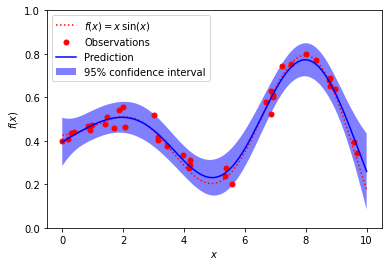

(1000, 1)


In [ ]:
import numpy as np
from matplotlib import pyplot as plt 
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as pl

np.random.seed(1)


def f(x):
    """The function to predict."""
    return x * np.sin(x)

x = np.atleast_2d(np.linspace(0, 10, 1000)).T

#X = np.linspace(0.1, 9.9, 20)
X = 10* np.random.random(40)
X = np.atleast_2d(X).T

# Observations and noise
y = f(X).ravel()
dy = 0.5 + 1.0 * np.random.random(y.shape[0])
noise = np.random.normal(0, dy)
y += noise
scaler = MinMaxScaler((0.2, 0.8))
y = scaler.fit_transform(y.reshape(-1, 1)).ravel()

# Instantiate a Gaussian Process model
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, alpha= 0.01,# dy ** 2,
                              n_restarts_optimizer=10)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure()
plt.plot(x, scaler.transform(f(x)), 'r:', label=r'$f(x) = x\,\sin(x)$')
plt.plot(X.ravel(), y, 'r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')
plt.fill_between(x[:,0], y_pred - 1.9600 * sigma, y_pred + 1.9600 * sigma,
         alpha=.5, fc='b', ec='None', label='95% confidence interval')

plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(0, 1)
plt.legend(loc='upper left')

plt.show()
print(x.shape)

In [ ]:
import qmc.tf.layers as layers
import qmc.tf.models as models
import tensorflow as tf

In [ ]:
#Model with a single QM-DM layer:

X = X.reshape((-1, 1))

sigma = 4
gamma = 1. / sigma ** 2

alpha = 0.02

n_comp = 64
random_state = 0

inputs_1 = tf.keras.Input(shape=(1,))
fm_x1_1 = layers.QFeatureMapRFF(1, dim=100 , gamma=gamma, random_state=17)
psi_x_1 = fm_x1_1(inputs_1)
ones = tf.ones_like(inputs_1[:, 0:1])
rho_x_1 = tf.keras.layers.concatenate((ones, psi_x_1), axis=1)
rho_x_1 = tf.expand_dims(rho_x_1, axis=-1)
qmdmc1_1 = layers.QMClassifSDecompFDMatrix(dim_x=100, dim_y=5, n_comp=n_comp)
rho_y = qmdmc1_1(rho_x_1)

y_w = rho_y[:, 0, :] # shape (b, d_in)
y_v = rho_y[:, 1:, :] # shape (b, dim_x, d_in)
probs = tf.einsum('...j,...ij,...ij->...i', y_w, y_v, tf.math.conj(y_v))
mean_var = layers.ProbRegression()(probs) #Computes the mean and std from probs

qmdmregressor = tf.keras.Model(inputs=inputs_1, outputs=mean_var)

In [ ]:
qmdmregressor.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 1)            0           input_1[0][0]                    
__________________________________________________________________________________________________
tf.ones_like (TFOpLambda)       (None, 1)            0           tf.__operators__.getitem[0][0]   
__________________________________________________________________________________________________
q_feature_map_rff (QFeatureMapR (None, 100)          200         input_1[0][0]                    
______________________________________________________________________________________________

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

def loss(y_true, y_pred):
    return tf.keras.losses.mean_squared_error(y_true, y_pred[:,0:1]) +  alpha * y_pred[:, 1:2]

qmdmregressor.compile(optimizer, loss=loss)
qmdmregressor.fit(X, y, epochs=300, verbose=0)

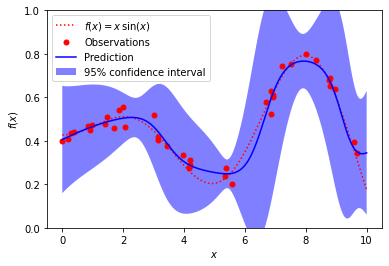

(1000, 1)


In [ ]:
# Plot the function, the prediction and the 95% confidence interval based on
# the MSE

out = qmdmregressor.predict(x.reshape((-1, 1)))
y_pred, std = out[:, 0], np.sqrt(out[:, 1])
plt.figure()
plt.plot(x, scaler.transform(f(x)), 'r:', label=r'$f(x) = x\,\sin(x)$')
plt.plot(X.ravel(), y, 'r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')
plt.fill_between(x[:,0], y_pred - 1.9600 * std, y_pred + 1.9600 * std,
         alpha=.5, fc='b', ec='None', label='95% confidence interval')

plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(0, 1)
plt.legend(loc='upper left')

plt.show()
print(x.shape)

In [ ]:
#Model two QM-DM layers:

X = X.reshape((-1, 1))

sigma = 4
gamma = 1. / sigma ** 2

alpha = 0.02

n_comp = 32
random_state = 0

inputs_1 = tf.keras.Input(shape=(1,))
fm_x1_1 = layers.QFeatureMapRFF(1, dim=100 , gamma=gamma, random_state=17)
psi_x_1 = fm_x1_1(inputs_1)
ones = tf.ones_like(inputs_1[:, 0:1])
rho_x_1 = tf.keras.layers.concatenate((ones, psi_x_1), axis=1)
rho_x_1 = tf.expand_dims(rho_x_1, axis=-1)
qmdmc1_1 = layers.QMClassifSDecompFDMatrix(dim_x=100, dim_y=32, n_comp=n_comp)
rho_y_1 = qmdmc1_1(rho_x_1)

qmdmc1_2 = layers.QMClassifSDecompFDMatrix(dim_x=32, dim_y=5, n_comp=n_comp)
rho_y_2 = qmdmc1_2(rho_y_1)

y_w = rho_y_2[:, 0, :] # shape (b, d_in)
y_v = rho_y_2[:, 1:, :] # shape (b, dim_x, d_in)
probs = tf.einsum('...j,...ij,...ij->...i', y_w, y_v, tf.math.conj(y_v))
mean_var = layers.ProbRegression()(probs) #Computes the mean and std from probs

qmdmregressor2 = tf.keras.Model(inputs=inputs_1, outputs=mean_var)

In [ ]:
qmdmregressor2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_3 (Sli (None, 1)            0           input_2[0][0]                    
__________________________________________________________________________________________________
tf.ones_like_1 (TFOpLambda)     (None, 1)            0           tf.__operators__.getitem_3[0][0] 
__________________________________________________________________________________________________
q_feature_map_rff_1 (QFeatureMa (None, 100)          200         input_2[0][0]                    
____________________________________________________________________________________________

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

def loss(y_true, y_pred):
    return tf.keras.losses.mean_squared_error(y_true, y_pred[:,0:1]) +  alpha * y_pred[:, 1:2]

qmdmregressor2.compile(optimizer, loss=loss)
qmdmregressor2.fit(X, y, epochs=300, verbose=0)

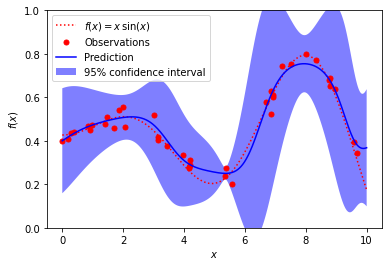

(1000, 1)


In [ ]:
# Plot the function, the prediction and the 95% confidence interval based on
# the MSE

out = qmdmregressor2.predict(x.reshape((-1, 1)))
y_pred, std = out[:, 0], np.sqrt(out[:, 1])
plt.figure()
plt.plot(x, scaler.transform(f(x)), 'r:', label=r'$f(x) = x\,\sin(x)$')
plt.plot(X.ravel(), y, 'r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')
plt.fill_between(x[:,0], y_pred - 1.9600 * std, y_pred + 1.9600 * std,
         alpha=.5, fc='b', ec='None', label='95% confidence interval')

plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(0, 1)
plt.legend(loc='upper left')

plt.show()
print(x.shape)